In [1]:
import sys
sys.path.insert(0, '../icenumerics')
import icenumerics as ice
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ureg = ice.ureg

from importlib import reload  
import shakti as sha
reload(sha)

from icenumerics.geometry import ordering 

%load_ext autoreload
%autoreload 2

# Ad Hoc modification of lattice and infer the vertices

In this script, I will try to build an alternative method to obtain the vertices of the shakti lattice. Using the already implemented functions 3-coordination vertices are not considered by the algorithm. My idea is to build a similar lattice that will obtain an object ice.vertices() that match with the one needed for the shakti.  

In [2]:
output = "/home/carolina/CairoLattice_ACI_PROJECT/Scripts/Output_Script-10.0"

In [3]:
def shakti_double_trap(trap_sep, part_d):

    """ Here, I follow the same structure as in the shakti lattice. The lattice is the same but
    I divided the long trap in two short ones."""

    trap_sep = 10
    part_d = 13*np.sqrt(2)
    plaquette_cte = part_d*2+2*trap_sep

    centers = np.array([
               [0,plaquette_cte/4,0], # <First plaquette>
               [0,-plaquette_cte/4,0],

               [-plaquette_cte/4, plaquette_cte/2,0],
               [plaquette_cte/4, plaquette_cte/2,0],
               [-plaquette_cte/4, -plaquette_cte/2,0],
               [plaquette_cte/4, -plaquette_cte/2,0],

               [3/4*plaquette_cte, 0, 0], # <Second plaquette>
               [5/4*plaquette_cte, 0, 0],

               [plaquette_cte/2,plaquette_cte/4, 0],
               [plaquette_cte/2,-plaquette_cte/4, 0],
               [(3/2)*plaquette_cte,plaquette_cte/4, 0],
               [(3/2)*plaquette_cte,-plaquette_cte/4, 0],

               [-1/4*plaquette_cte,-plaquette_cte, 0], # <Third plaquette>
               [+1/4*plaquette_cte,-plaquette_cte, 0],

               [-plaquette_cte/2, -3/4*plaquette_cte,0],
               [-plaquette_cte/2, -5/4*plaquette_cte,0],
               [+plaquette_cte/2, -3/4*plaquette_cte,0],
               [+plaquette_cte/2, -5/4*plaquette_cte,0],

               [plaquette_cte, -3/4*plaquette_cte,0], # <Fourth plaquette>
               [plaquette_cte, -5/4*plaquette_cte,0],

               [3/4*plaquette_cte, -plaquette_cte/2,0],
               [5/4*plaquette_cte, -plaquette_cte/2,0],
               [3/4*plaquette_cte, -3/2*plaquette_cte,0],
               [5/4*plaquette_cte, -3/2*plaquette_cte,0],
              ])*ureg.um

    trap_sep = 10
    directions = np.array([
                  [0,trap_sep,0], # <First plaquette>
                  [0,trap_sep,0],

                  [trap_sep,0,0],
                  [trap_sep,0,0],
                  [trap_sep,0,0],
                  [trap_sep,0,0],

                  [trap_sep,0,0], # <Second plaquette>
                  [trap_sep,0,0],

                  [0,trap_sep,0],
                  [0,trap_sep,0],
                  [0,trap_sep,0],
                  [0,trap_sep,0],

                  [trap_sep,0,0], #  <Third plaquette>
                  [trap_sep,0,0],

                  [0,trap_sep,0],
                  [0,trap_sep,0],
                  [0,trap_sep,0],
                  [0,trap_sep,0],

                  [0,trap_sep,0], # <Fourth plaquette>
                  [0,trap_sep,0], 

                  [trap_sep,0,0],
                  [trap_sep,0,0],
                  [trap_sep,0,0],
                  [trap_sep,0,0],
                 ])*ureg.um
    
    return centers, directions

In [4]:
centers, directions = shakti_double_trap(10,13*np.sqrt(2))

(-35.051731573020284,
 91.82128419472076,
 -91.82128419472076,
 35.051731573020284)

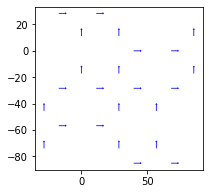

In [5]:
sp = ice.spins(centers = centers, directions = directions)

f, (ax1) = plt.subplots(1,1,figsize = (3,3))
sp.display(ax1)
plt.axis('equal')


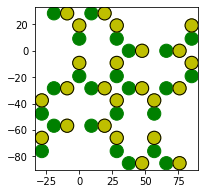

In [6]:
particle = ice.particle(radius = 5*ureg.um,
             susceptibility = 0.005,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = 10*ureg.um,
               height = 30*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)


col = ice.colloidal_ice(sp, particle, trap, height_spread = 0, susceptibility_spread = 0.1)
col.pad_region(5*ureg.um)

f, (ax1) = plt.subplots(1,1,figsize = (3,3))

col.display(ax1)

In [7]:
world = ice.world(
    field = 25*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)
#   boundaries = ["p", "p", "p"])

total_time = 10*ureg.s
col.simulate(world,
             name = "shakti_test",
             include_timestamp = False,
             targetdir = output,
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = total_time,
             output = ["x","y","z","mux","muy","muz"])

col.sim.field.fieldz = "v_Bmag*time/%f"%(total_time.to(ureg.us).magnitude)
col.run_simulation()

col.load_simulation(slice(0,None,10))

scanning file


scanning file


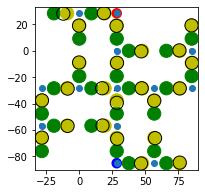

In [8]:
f, (ax1) = plt.subplots(1,1,figsize = (3,3))
v = ice.vertices()
col.set_state_from_frame(-1)
v = v.colloids_to_vertices(col)

col.display(ax1)
v.display(ax1)
v.vertices.groupby('charge').count()

plt.plot(v.vertices['x'].values,v.vertices['y'].values, 'o')

Let's see what's happening in v.edges dataframe. And if it needs some modifications. 

In [9]:
def edges_shakti(df):
    
    start = []
    end = []
    all_values = list(range(0,len(df)))
    removed_values = list(range(0,len(df),6))
    changed_values = list(range(1,len(df),6))

    copied_values = set(all_values)-set(removed_values)-set(changed_values)
    copied_values_list = list(copied_values)
    
    for i in range(0,len(df)):
        
        if i in changed_values:
        
            if df.loc[i-1]['start'] > df.loc[i]['start']:

                start.append(df.loc[i-1]['start'])
                
            elif df.loc[i-1]['start'] == df.loc[i]['start']:

                one = df.loc[i-1]['end']
                two = df.loc[i]['end']
            
                start.append(min(one,two))
                
            else:

                start.append(df.loc[i]['start'])

            if df.loc[i-1]['end'] > df.loc[i]['end']:

                end.append(df.loc[i-1]['end'])
                
            elif df.loc[i-1]['end'] == df.loc[i]['end']:

                one = df.loc[i-1]['start']
                two = df.loc[i]['start']
            
                end.append(min(one,two))
            else:

                end.append(df.loc[i]['end'])
                
        elif i in copied_values_list:
            
            start.append(df.loc[i]['start'])
            end.append(df.loc[i]['end'])
            
            
    return np.array([start,end]).T

In [10]:
edges_shakti_values = edges_shakti(v.edges)

In [11]:
edges_shakti_values

array([[ 2,  5],
       [-1,  5],
       [ 5,  4],
       [ 1,  2],
       [ 2,  3],
       [10,  6],
       [10,  4],
       [ 3, 10],
       [ 6, -1],
       [11,  6],
       [ 0,  7],
       [ 0,  1],
       [-1,  0],
       [ 7,  3],
       [ 8,  7],
       [ 9, 12],
       [ 3, 12],
       [12, 11],
       [ 8,  9],
       [ 9, -1]])

In [12]:
v.vertices[["x","y"]].values

array([[-28.38477631, -56.76955262],
       [-28.38477631, -28.38477631],
       [  0.        , -28.38477631],
       [ 28.38477631, -28.38477631],
       [ 28.38477631,  28.38477631],
       [  0.        ,  28.38477631],
       [ 85.15432893,   0.        ],
       [ 28.38477631, -56.76955262],
       [ 28.38477631, -85.15432893],
       [ 56.76955262, -85.15432893],
       [ 28.38477631,   0.        ],
       [ 85.15432893, -28.38477631],
       [ 56.76955262, -28.38477631]])

We have it! Let's try to introduce this information in the object v.vertices for the shakti as a doblecheck!

In [13]:
trap_sep = 10
part_d = 13*np.sqrt(2)
plaquette_cte = part_d*2+2*trap_sep

centers = np.array([[0,0,0], # <First plaquette>
           [-plaquette_cte/4, plaquette_cte/2,0],
           [plaquette_cte/4, plaquette_cte/2,0],
           [-plaquette_cte/4, -plaquette_cte/2,0],
           [plaquette_cte/4, -plaquette_cte/2,0],

           [plaquette_cte, 0, 0], # <Second plaquette>
           [plaquette_cte/2,plaquette_cte/4, 0],
           [plaquette_cte/2,-plaquette_cte/4, 0],
           [(3/2)*plaquette_cte,plaquette_cte/4, 0],
           [(3/2)*plaquette_cte,-plaquette_cte/4, 0],

           [0,-plaquette_cte, 0], # <Third plaquette>
           [-plaquette_cte/2, -3/4*plaquette_cte,0],
           [-plaquette_cte/2, -5/4*plaquette_cte,0],
           [+plaquette_cte/2, -3/4*plaquette_cte,0],
           [+plaquette_cte/2, -5/4*plaquette_cte,0],
           
           [plaquette_cte, -plaquette_cte,0], # <Fourth plaquette>
           [3/4*plaquette_cte, -plaquette_cte/2,0],
           [5/4*plaquette_cte, -plaquette_cte/2,0],
           [3/4*plaquette_cte, -3/2*plaquette_cte,0],
           [5/4*plaquette_cte, -3/2*plaquette_cte,0],
          ])*ureg.um

a = 1
directions = np.array([[0,trap_sep*a,0], # <First plaquette>
              [1*a,0,0],
              [1*a,0,0],
              [1*a,0,0],
              [1*a,0,0],
              [trap_sep*a,0,0], # <Second plaquette>
              [0,1*a,0],
              [0,1*a,0],
              [0,1*a,0],
              [0,1*a,0],
              [trap_sep*a,0,0], #  <Third plaquette>
              [0,1*a,0],
              [0,1*a,0],
              [0,1*a,0],
              [0,1*a,0],
              [0,trap_sep*a,0], # <Fourth plaquette>
              [1*a,0,0],
              [1*a,0,0],
              [1*a,0,0],
              [1*a,0,0],
             ])*ureg.um

(-34.160731573020286,
 90.93028419472077,
 -90.93028419472077,
 34.160731573020286)

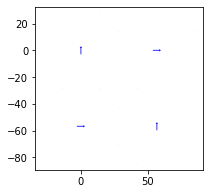

In [14]:
sp = ice.spins(centers = centers, directions = directions)

f, (ax1) = plt.subplots(1,1,figsize = (3,3))
sp.display(ax1)
plt.axis('equal')

In [15]:
particle = ice.particle(radius = 5*ureg.um,
             susceptibility = 0.005,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap_short = ice.trap(trap_sep = 10*ureg.um,
               height = 30*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)

trap_long = ice.trap(trap_sep = (20+13*np.sqrt(2))*ureg.um,
               height = 30*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)

In [16]:
lattice_constant = 10
traps = []

for s in sp:
    
    if ( s.direction[0].magnitude >= lattice_constant or s.direction[0].magnitude <= -lattice_constant or 
        s.direction[1].magnitude >= lattice_constant or s.direction[1].magnitude <= -lattice_constant):
        
        traps.append(trap_long)
        
    else:
        
        traps.append(trap_short)

In [17]:
col = ice.colloidal_ice(sp, particle, traps, height_spread = 0, susceptibility_spread = 0.1)
col.pad_region(5*ureg.um)

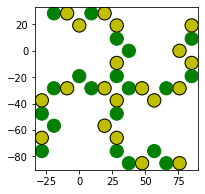

In [18]:
f, (ax1) = plt.subplots(1,1,figsize = (3,3))

col.display(ax1)

In [19]:
world = ice.world(
    field = 25*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)
#   boundaries = ["p", "p", "p"])

total_time = 10*ureg.s
col.simulate(world,
             name = "shakti_test",
             include_timestamp = False,
             targetdir = output,
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = total_time,
             output = ["x","y","z","mux","muy","muz"])

col.sim.field.fieldz = "v_Bmag*time/%f"%(total_time.to(ureg.us).magnitude)
col.run_simulation()

col.load_simulation(slice(0,None,10))

scanning file


scanning file


In [20]:
v_non_inferred = ice.vertices(
    positions = v.vertices[["x","y"]].values,
    edges = edges_shakti_values)

In [21]:
v_non_inferred.update_directions(col)

In [22]:
v_non_inferred.classify_vertices(ice.ice_to_spins(col))

In [23]:
a = v_non_inferred.vertices.query('coordination == 2')

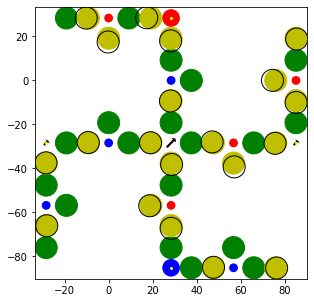

In [24]:
f, (ax1) = plt.subplots(1,1,figsize = (5,5))



ax1.plot(a['x'],a['y'], 'o', color = 'yellow', markersize = 2)
col.display(ax1)
v_non_inferred.display(ax1)

Works!! Now 3-coordination vertices in the shakti lattice are correctly readed.

Let's build now a 10x10 lattice, save the vertices positions and edges as a dataframe to import them for future simulations and analysis.

In [41]:
Sx = 10
Sy = 10

In [42]:
sp = sha.spins()
ureg = ice.ureg
sp.create_lattice(geometry = "shakti",size =[Sx,Sy],lattice_constant=1*ureg.um , border="short trap")
sp.order_spins(ordering.random_ordering)

/home/carolina/CairoLattice_ACI_PROJECT/Scripts/shakti.py:254: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new_centers[:,1] = centersY


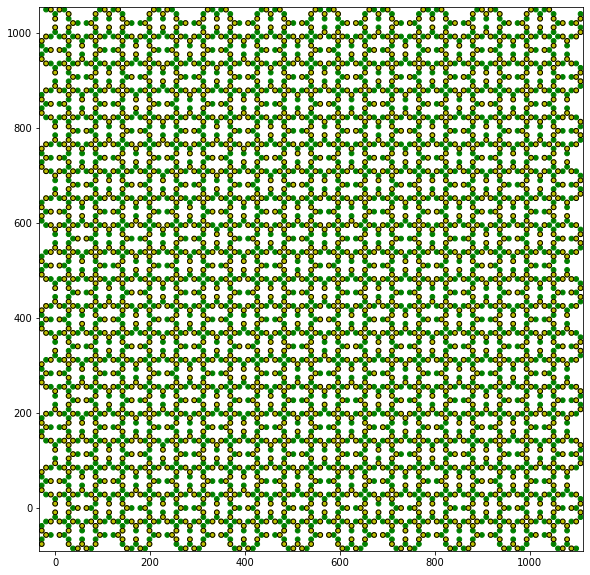

In [43]:
particle = ice.particle(radius = 5*ureg.um,
             susceptibility = 0.005,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = 10*ureg.um,
               height = 30*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)


col = ice.colloidal_ice(sp, particle, trap, height_spread = 0, susceptibility_spread = 0.1)
col.pad_region(5*ureg.um)

f, (ax1) = plt.subplots(1,1,figsize = (10,10))

col.display(ax1)

In [44]:
world = ice.world(
    field = 25*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)
#   boundaries = ["p", "p", "p"])

total_time = 10*ureg.s
col.simulate(world,
             name = "shakti_test",
             include_timestamp = False,
             targetdir = output,
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = total_time,
             output = ["x","y","z","mux","muy","muz"])

col.sim.field.fieldz = "v_Bmag*time/%f"%(total_time.to(ureg.us).magnitude)
col.run_simulation()

col.load_simulation(slice(0,None,10))

scanning file


scanning file


,x,y,coordination,dx,dy
charge,,,,,
-4,28,28,28,28,28
-3,100,100,100,100,100
-2,97,97,97,97,97
-1,293,293,293,293,293
0,161,161,161,161,161
1,314,314,314,314,314
2,125,125,125,125,125
3,93,93,93,93,93
4,26,26,26,26,26


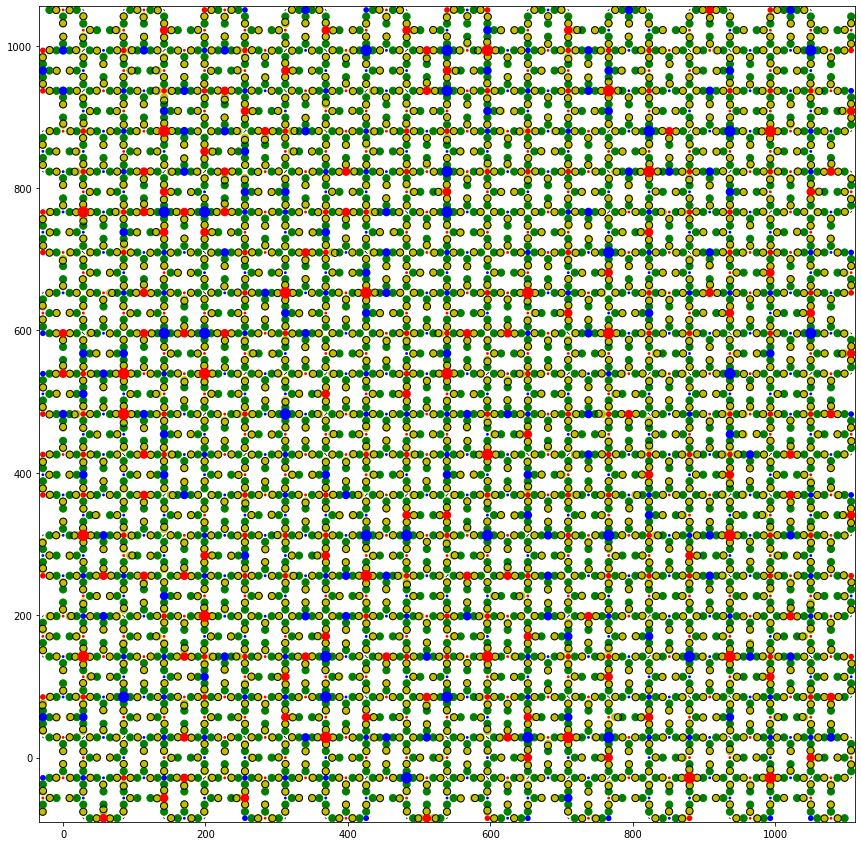

In [45]:
f, (ax1) = plt.subplots(1,1,figsize = (15,15))
v = ice.vertices()
col.set_state_from_frame(-1)
v = v.colloids_to_vertices(col)

col.display(ax1)
v.display(ax1)
v.vertices.groupby('charge').count()

In [46]:
a = v.vertices.query('coordination == 2')

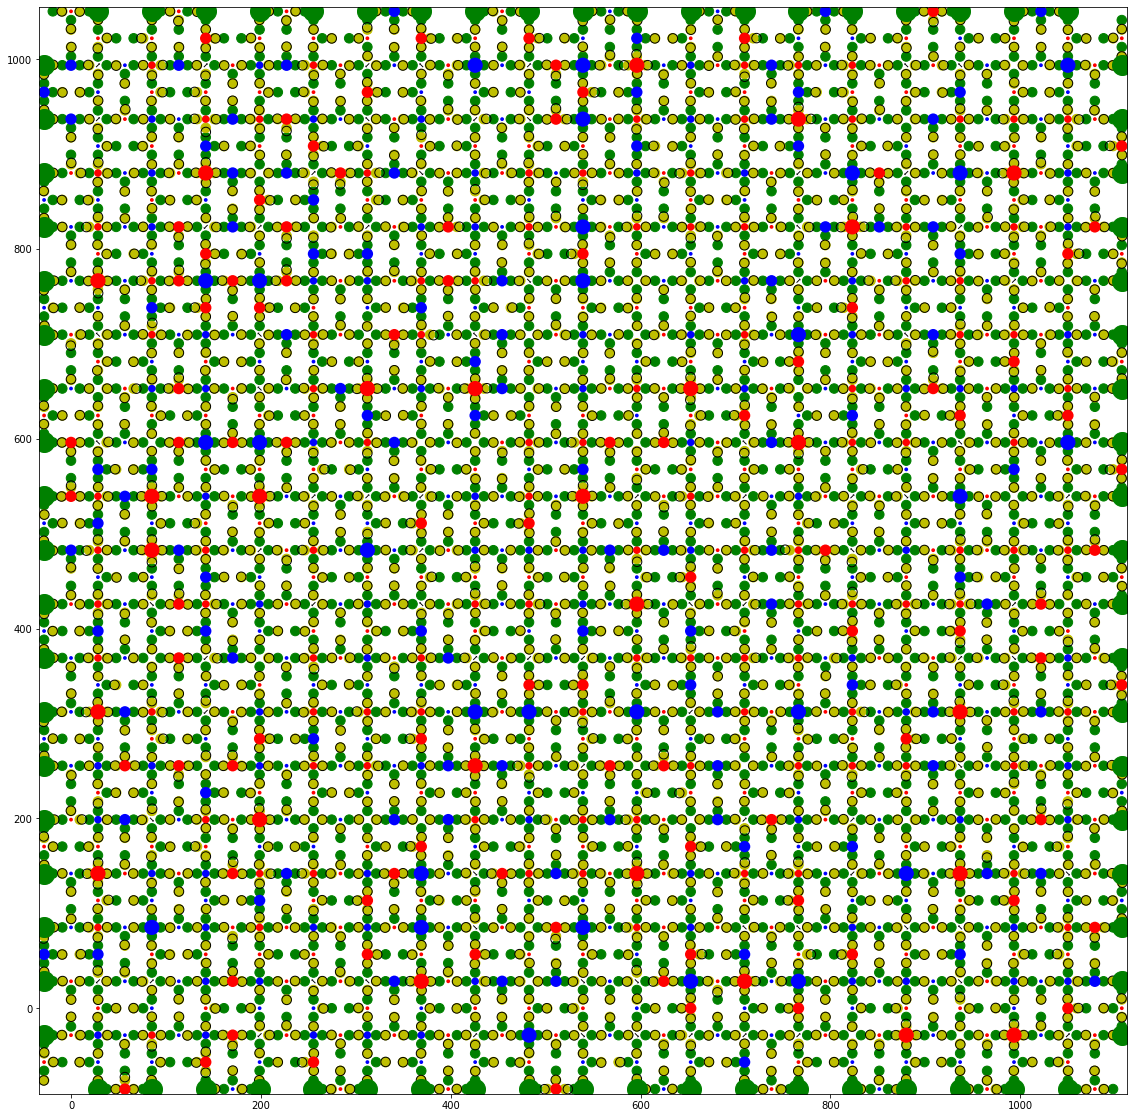

In [47]:
f, (ax1) = plt.subplots(1,1,figsize = (20,20))



ax1.plot(a['x'],a['y'], 'o', color = 'green', markersize = 20)
col.display(ax1)
v.display(ax1)

In [48]:
edges_shakti_values = edges_shakti(v.edges)

In [49]:
edges_shakti_values

array([[ 119,  115],
       [ 113,  119],
       [ 117,  119],
       [ 114,  115],
       [ 116,  115],
       [ 842,  593],
       [ 117,  593],
       [ 116,  593],
       [ 842,  591],
       [ 588,  842],
       [ 281,    0],
       [ 114,    0],
       [   0,   -1],
       [ 116,  281],
       [ 281,  120],
       [ 121,  841],
       [ 841,  116],
       [ 841,  588],
       [ 120,  121],
       [1229,  121],
       [ 839,  589],
       [ 591,  839],
       [ 839,  837],
       [ 589,  588],
       [ 840,  589],
       [1090, 1159],
       [ 837, 1090],
       [1090,  840],
       [1159,  705],
       [1159,  701],
       [ 546,  548],
       [ 548,  588],
       [ 548, 1229],
       [ 840,  546],
       [ 547,  546],
       [ 411,  196],
       [ 840,  196],
       [ 701,  196],
       [ 411,  547],
       [ 412,  411],
       [ 938,  409],
       [ 705,  938],
       [ 410,  938],
       [ 409,  701],
       [ 414,  409],
       [ 703, 1053],
       [ 703,  410],
       [ 703,

In [50]:
np.set_printoptions(threshold=sys.maxsize)

In [51]:
v.edges.values

array([[ 119,   -1],
       [ 115,   -1],
       [ 113,  119],
       [ 117,  119],
       [ 114,  115],
       [ 116,  115],
       [ 593,   -1],
       [ 842,   -1],
       [ 117,  593],
       [ 116,  593],
       [ 842,  591],
       [ 588,  842],
       [  -1,    0],
       [ 281,   -1],
       [ 114,    0],
       [   0,   -1],
       [ 116,  281],
       [ 281,  120],
       [  -1,  841],
       [  -1,  121],
       [ 841,  116],
       [ 841,  588],
       [ 120,  121],
       [1229,  121],
       [ 839,   -1],
       [ 589,   -1],
       [ 591,  839],
       [ 839,  837],
       [ 589,  588],
       [ 840,  589],
       [  -1, 1090],
       [  -1, 1159],
       [ 837, 1090],
       [1090,  840],
       [1159,  705],
       [1159,  701],
       [  -1,  548],
       [  -1,  546],
       [ 548,  588],
       [ 548, 1229],
       [ 840,  546],
       [ 547,  546],
       [  -1,  196],
       [ 411,   -1],
       [ 840,  196],
       [ 701,  196],
       [ 411,  547],
       [ 412,

In [52]:
edges_shakti_values

array([[ 119,  115],
       [ 113,  119],
       [ 117,  119],
       [ 114,  115],
       [ 116,  115],
       [ 842,  593],
       [ 117,  593],
       [ 116,  593],
       [ 842,  591],
       [ 588,  842],
       [ 281,    0],
       [ 114,    0],
       [   0,   -1],
       [ 116,  281],
       [ 281,  120],
       [ 121,  841],
       [ 841,  116],
       [ 841,  588],
       [ 120,  121],
       [1229,  121],
       [ 839,  589],
       [ 591,  839],
       [ 839,  837],
       [ 589,  588],
       [ 840,  589],
       [1090, 1159],
       [ 837, 1090],
       [1090,  840],
       [1159,  705],
       [1159,  701],
       [ 546,  548],
       [ 548,  588],
       [ 548, 1229],
       [ 840,  546],
       [ 547,  546],
       [ 411,  196],
       [ 840,  196],
       [ 701,  196],
       [ 411,  547],
       [ 412,  411],
       [ 938,  409],
       [ 705,  938],
       [ 410,  938],
       [ 409,  701],
       [ 414,  409],
       [ 703, 1053],
       [ 703,  410],
       [ 703,

In [53]:
v.vertices[["x","y"]]

,x,y
0,-28.384776,-56.769553
1,1107.006276,1021.851947
2,1050.236724,1050.236724
3,965.082395,709.619408
4,823.158513,1021.851947
...,...,...
1232,1107.006276,709.619408
1233,652.849855,-85.154329
1234,-28.384776,936.697618
1235,-28.384776,823.158513


In [54]:
edges = pd.DataFrame(data=edges_shakti_values , columns=["start", "stop"])

edges

,start,stop
0,119,115
1,113,119
2,117,119
3,114,115
4,116,115
...,...,...
1995,983,984
1996,982,983
1997,983,771
1998,984,1078


In [55]:
edges.to_csv('edges_shakti_'+str(Sx)+'x'+str(Sy)+'.dat')

In [56]:
v.vertices[["x","y"]].to_csv('vertices_shakti_'+str(Sx)+'x'+str(Sy)+'.dat')

Done!